In [3]:
import pandas as pd
import glob
#from sklearn.model_selection import cross_val_score, train_test_split
#from sklearn.linear_model import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

pickle_path = 'param_chunks' #Same Path as out_path i.e. where the pickle files are

data_p_files=[]
for name in glob.glob(pickle_path + "/data_*.pkl"):
   data_p_files.append(name)


df = pd.DataFrame()
for i in range(len(data_p_files)):
    data_chunk = pd.read_pickle(data_p_files[i])
    #df = df.append(data_chunk,ignore_index=True)
    df = pd.concat([df,data_chunk],ignore_index=True)

In [4]:
df

,ID,FEN,RESULT,PHASE_0,PHASE_1,MAT_0_0,MAT_0_1,MAT_0_2,MAT_0_3,MAT_0_4,...,ROOK_ATT_1_5,QN_ATT_1_0,QN_ATT_1_1,QN_ATT_1_2,QN_ATT_1_3,QN_ATT_1_4,QN_ATT_1_5,DOUBL_1,BISH_PAIR_1,Unnamed: 1173
0,0,r2qkr2/p1pp1ppp/1pn1pn2/2P5/3Pb3/2N1P3/PP3PPP/...,-1,19,29,8,1,2,2,0,...,0,0,0,0,0,0,0,0,0,NaN
1,1,r4rk1/3bppb1/p3q1p1/1p1p3p/2pPn3/P1P1PN1P/1PB1...,0,29,29,8,1,2,2,1,...,0,0,0,0,0,0,0,0,1,NaN
2,2,4Q3/8/8/8/6k1/4K2p/3N4/5q2 b - -,-1,13,10,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,NaN
3,3,r4rk1/1Qpbq1bp/p1n2np1/3p1p2/3P1P2/P1NBPN1P/1P...,-1,32,32,7,2,2,2,1,...,0,0,0,0,0,0,0,0,1,NaN
4,4,r1bqk2r/2p2ppp/2p5/p3pn2/1bB5/2NP2P1/PPP1NP1P/...,-1,22,29,7,2,2,2,0,...,0,0,0,0,0,0,0,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427995,1427995,2k2b1r/2p2ppb/p2p2qp/1p1P4/nPnNrPPP/6BB/P1Q1N3...,1,32,32,6,2,2,2,1,...,0,0,0,0,0,0,0,0,1,NaN
1427996,1427996,r4rk1/1nq1b1p1/6p1/p3pp2/2P1N3/2Q1B1PP/PP4B1/R...,1,29,26,5,1,2,2,1,...,0,0,0,0,0,0,0,1,0,NaN
1427997,1427997,2r1kbnr/pp1b1ppp/1q2p3/3pP3/3P4/P4N2/1PB2PPP/1...,-1,27,29,7,2,2,1,1,...,0,0,0,0,0,0,0,0,1,NaN
1427998,1427998,r2q1rk1/pp2b1pp/3pbn2/2p1pp2/1PP3n1/P1NP1NP1/3...,1,32,32,8,2,2,2,1,...,0,0,0,0,0,0,0,0,1,NaN


In [5]:
df['PHASE_0'] = df['PHASE_0'].clip(0,32)
df['PHASE_1'] = df['PHASE_1'].clip(0,32)
df['phase'] = (df['PHASE_0']+df['PHASE_1'])/64

wh = np.r_[df.columns.get_loc('MAT_0_0'):(df.columns.get_loc('BISH_PAIR_0')+1)]  
bl = np.r_[df.columns.get_loc('MAT_1_0'):(df.columns.get_loc('BISH_PAIR_1')+1)] 

pos_white = df.iloc[:, wh].to_numpy(dtype=np.float16)
pos_black = df.iloc[:, bl].to_numpy(dtype=np.float16)
pos = pos_white-pos_black
result = (df['RESULT'].to_numpy(dtype=np.float16)+1)/2
phase = df['phase'].to_numpy()

<Axes: ylabel='Count'>

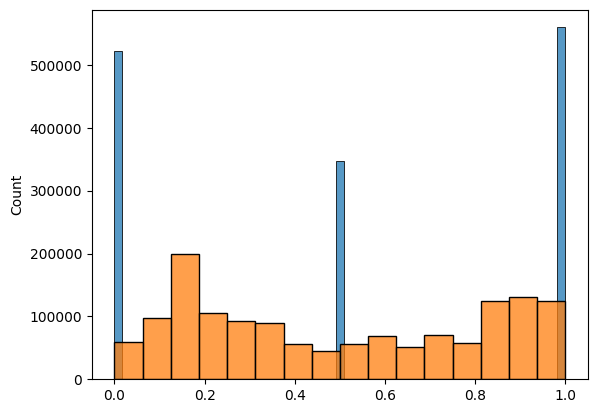

In [6]:
import seaborn as sns
sns.histplot(data=result)
sns.histplot(data=phase, bins=16)

In [7]:
print(f"Phase stats:")
print(np.min(phase))
print(np.mean(phase))
print(np.max(phase))

print(f"Result stats:")
print(np.min(result))
print(np.median(result))
print(np.max(result))

print(f"pos.shape: {pos.shape}")

print(f"df.shape: {df.shape}")

Phase stats:
0.0
0.49014490327380955
1.0
Result stats:
0.0
0.5
1.0
pos.shape: (1428000, 584)
df.shape: (1428000, 1175)


In [8]:
del df

pos = torch.as_tensor(pos, dtype=torch.float32)
result = torch.as_tensor(result, dtype=torch.float32)
phase = torch.as_tensor(phase, dtype=torch.float32)
#phase = torch.clamp((phase-0.5)*1.2+0.5, 0.0, 1.0)

In [9]:
import torch.nn.init as init

class LogisticModel(torch.nn.Module):
    def __init__(self, input_dim):
        super(LogisticModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, 1, bias=False)
        self.linear2 = torch.nn.Linear(input_dim, 1, bias=False)
        self.activation = torch.nn.Sigmoid()

        # Initialize weights using the custom initialization
        self.initialize_weights()

    def initialize_weights(self):
        # Set all weights to zero
        self.linear1.weight.data.zero_()
        self.linear2.weight.data.zero_()

        # Set the first 5 weights to specified values
        self.linear1.weight.data[0,:5] = torch.tensor([100.0, 300.0, 325.0, 500.0, 900.0])
        self.linear2.weight.data[0,:5] = torch.tensor([100.0, 300.0, 325.0, 500.0, 900.0])

    def forward(self, x, ph):
        K = 0.00916
        x1 = self.linear1(torch.einsum('i,ij->ij', ph, x))*K
        x2 = self.linear2(torch.einsum('i,ij->ij', (1-ph), x))*K

        result = self.activation(x1+x2)
        return result.to(dtype=torch.float32)

In [33]:
model = LogisticModel(pos.shape[1])

#ce = nn.BCELoss()
#ce = nn.MSELoss()
#ce = nn.L1Loss()
ce = nn.SmoothL1Loss(beta=0.25)
#ce = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.25)

epochs = 50000
for epoch in range(epochs):
    res_pred = model(pos, phase)[:, 0]
    
    loss = ce(res_pred, result)
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()  
    mse = torch.mean((res_pred-result)**2)
    print(f"epoch = {epoch}, loss = {loss}, mse = {mse}")
    if epoch % 3 == 0:
        est_param1 = model.linear1.weight.detach().numpy().astype(int)
        est_param2 = model.linear2.weight.detach().numpy().astype(int)
        print(f"Piece val mg: {est_param1[0,0:5]}, Piece val eg: {est_param2[0,0:5]}")

    if epoch % 5000 == 0:
        torch.save(model.state_dict(), 'epoch-{}.pth'.format(epoch))

print("Done!")

epoch = 0, loss = 0.10944918543100357, mse = 0.07306714355945587
Piece val mg: [ 99 300 325 499 900], Piece val eg: [100 300 324 499 900]
epoch = 1, loss = 0.1090855672955513, mse = 0.07274702191352844
epoch = 2, loss = 0.10873444378376007, mse = 0.07243988662958145
epoch = 3, loss = 0.10839579254388809, mse = 0.07214540243148804
Piece val mg: [ 99 300 326 499 900], Piece val eg: [100 300 324 499 900]
epoch = 4, loss = 0.10806943476200104, mse = 0.07186327874660492
epoch = 5, loss = 0.10775519907474518, mse = 0.07159320265054703
epoch = 6, loss = 0.10745291411876678, mse = 0.07133490592241287
Piece val mg: [ 98 301 326 498 901], Piece val eg: [101 301 323 498 901]
epoch = 7, loss = 0.1071624681353569, mse = 0.07108812779188156
epoch = 8, loss = 0.10688360035419464, mse = 0.07085255533456802
epoch = 9, loss = 0.10661609470844269, mse = 0.07062789052724838
Piece val mg: [ 97 302 327 497 902], Piece val eg: [102 302 322 497 902]
epoch = 10, loss = 0.10635963827371597, mse = 0.070413731038

In [18]:
torch.save(model,"model_final.pth")

In [25]:
est_param = model.linear1.weight.detach().numpy().astype(int)
est_param[0,0:6]

array([  88,  380,  416,  570, 1132,    0])

In [26]:
est_param = model.linear2.weight.detach().numpy().astype(int)
est_param[0,0:6]

array([105, 238, 278, 454, 833,   0])

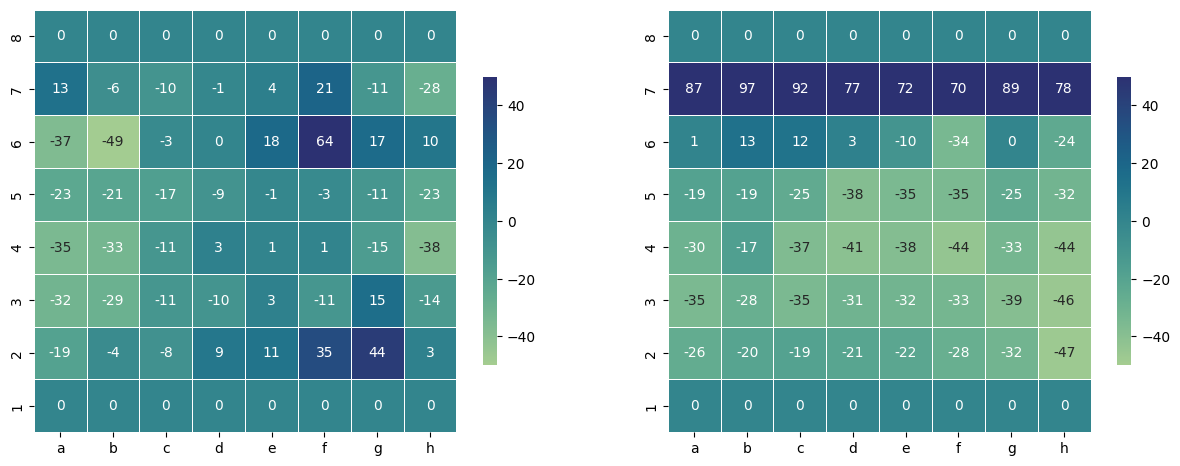

In [27]:
est_param1 = model.linear1.weight.detach().numpy().astype(int)
est_param2 = model.linear2.weight.detach().numpy().astype(int)

piece = 0
board1 = est_param1[0,(6+piece*64):(6+(piece+1)*64)]
board1 = np.reshape(board1, (8, 8))
board1 = np.flipud(board1)

board2 = est_param2[0,(6+piece*64):(6+(piece+1)*64)]
board2 = np.reshape(board2, (8, 8))
board2 = np.flipud(board2)

import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))
#fig.subplots_adjust(wspace=0.05)
mmax = 50

sns.heatmap(board1, cmap='crest', annot=True, annot_kws={"size": 10}, fmt='.3g', cbar=True, linewidths=.5, ax=ax1, square=True, cbar_kws={'shrink': .25}, vmin=-mmax, vmax=mmax)
ax1.set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
ax1.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])

sns.heatmap(board2, cmap='crest', annot=True, annot_kws={"size": 10}, fmt='.3g', cbar=True, linewidths=.5, ax=ax2, square=True, cbar_kws={'shrink': .25}, vmin=-mmax, vmax=mmax)
ax2.set_xticklabels(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
ax2.set_yticklabels(['8', '7', '6', '5', '4', '3', '2', '1'])

plt.show()


<Axes: ylabel='Count'>

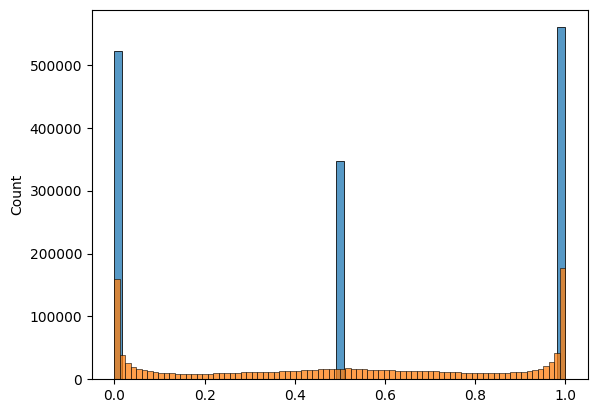

In [28]:
import seaborn as sns
sns.histplot(data=result.detach().numpy())
sns.histplot(data=res_pred.detach().numpy())


In [29]:
torch.mean((res_pred-result)**2)

tensor(0.0625, grad_fn=<MeanBackward0>)

In [30]:
# Lengths of each field
length_of_fields = [6, 64, 64, 64, 64, 64, 64, 64, 8, 8, 8, 8, 9, 14, 15, 28, 6, 6, 6, 6, 6, 1, 1]

vector = model.linear1.weight.detach().numpy().astype(int).reshape(-1)
# Save the vector into a text file
with open('output_mg.txt', 'w') as file:
    start_index = 0
    for field_length in length_of_fields:
        # Extract the part of the vector corresponding to the current field
        field_vector = vector[start_index:(start_index + field_length)]
        # Convert the field vector to string and write to file
        file.write('{')
        file.write(', '.join(map(str, field_vector)) + '}\n')
        # Update the start index for the next field
        start_index += field_length
        #print(f"start_index: {start_index}, field_length: {field_length}, field_vector: {field_vector}")

vector = model.linear2.weight.detach().numpy().astype(int).reshape(-1)
with open('output_eg.txt', 'w') as file:
    start_index = 0
    for field_length in length_of_fields:
        # Extract the part of the vector corresponding to the current field
        field_vector = vector[start_index:start_index + field_length]
        # Convert the field vector to string and write to file
        file.write('{')
        file.write(', '.join(map(str, field_vector)) + '}\n')
        # Update the start index for the next field
        start_index += field_length

def replace_placeholders(output_file, params_file, updated_params_file):
    # Read all lines from the output file
    with open(output_file, 'r') as file:
        output_lines = file.readlines()

    # Read all lines from the parameters file
    with open(params_file, 'r') as file:
        params_lines = file.readlines()

    # Replace '{}' in each line of the params file with the corresponding line from the output file
    updated_lines = [params_line.replace('{}', output_line.strip()) for params_line, output_line in zip(params_lines, output_lines)]

    # Write the updated lines to a new file
    with open(updated_params_file, 'w') as file:
        file.writelines(updated_lines)
        file.write('\n')

def merge_files(file1, file2, output_file):
    with open(file1, 'r') as f1, open(file2, 'r') as f2, open(output_file, 'w') as out:
        lines1 = f1.readlines()
        lines2 = f2.readlines()

        for line1, line2 in zip(lines1, lines2):
            out.write(line1)
            out.write(line2)
            out.write('\n')

        # If one file is longer than the other, write the remaining lines
        remaining_lines = lines1[len(lines2):] if len(lines1) > len(lines2) else lines2[len(lines1):]
        for line in remaining_lines:
            out.write(line)


# Example usage:
replace_placeholders('output_mg.txt', 'mg_params.txt', 'updated_mg_params.txt')
replace_placeholders('output_eg.txt', 'eg_params.txt', 'updated_eg_params.txt')
merge_files('updated_mg_params.txt', 'updated_eg_params.txt', 'merged_params.txt')